# RAMP on text classification

*Moustapha Mohamed Mahmoud, Mohamed Vadhel Ebnou Oumar, Sonali Patekar, Niclas Tollot, Abdellahi Ebnou Oumar, Yao ?*

## Introduction

## Getting started with the RAMP starting kit

### Download the necessary libraries

In [1]:
!pip install -r requirements.txt

## Downloading the data

Download the entire dataset in the data folder and split it into a train and a test dataset  


In [2]:
!python download_data.py

The data has been successfully downloaded and saved.


### Imports

In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [4]:
tf.__version__

'2.10.1'

### The Data

In [5]:
df_train = pd.read_csv('data/train_data.csv')
df_test = pd.read_csv('data/test_data.csv')

In [6]:
df_train.head()

,Topic,Sentiment,TweetId,TweetDate,TweetText
0,twitter,irrelevant,126866905096130560,Thu Oct 20 03:46:41 +0000 2011,Ninguem fala cmgo no #Twitter!
1,microsoft,neutral,126704776506380288,Wed Oct 19 17:02:27 +0000 2011,Two Extremes of Touch Interaction #Microsoft #...
2,microsoft,neutral,126514187647201280,Wed Oct 19 04:25:07 +0000 2011,Should #Microsoft and #Google design their sof...
3,twitter,negative,126872316142559232,Thu Oct 20 04:08:12 +0000 2011,#twitter show my fuckin retweets bitch
4,twitter,irrelevant,126867000030007296,Thu Oct 20 03:47:04 +0000 2011,"jajajajaja PTM!! Gigo, si tuvieras #Twitter ll..."


In [7]:
df_train.shape

(4090, 5)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4090 entries, 0 to 4089
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Topic      4090 non-null   object
 1   Sentiment  4090 non-null   object
 2   TweetId    4090 non-null   int64 
 3   TweetDate  4090 non-null   object
 4   TweetText  4090 non-null   object
dtypes: int64(1), object(4)
memory usage: 159.9+ KB


#### No missing value among the 5 features

In [9]:
df_train.isnull().sum()

Topic        0
Sentiment    0
TweetId      0
TweetDate    0
TweetText    0
dtype: int64

In [10]:
df_train['Sentiment'].unique()

array(['irrelevant', 'neutral', 'negative', 'positive'], dtype=object)

<AxesSubplot: title={'center': 'Frequency of occurrence of sentiment'}>

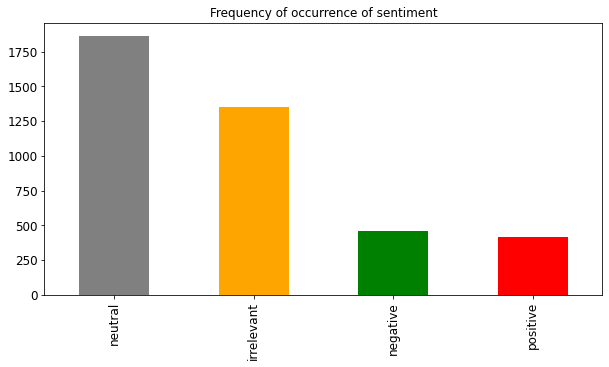

In [15]:
df_train['Sentiment'].value_counts().plot(kind='bar', color=['grey', 'orange', 'green', 'red'], figsize=(10, 5),\
    fontsize=12, title='Frequency of occurrence of sentiment')

#### Extract the labels

In [30]:
train_texts = df_train.drop('Sentiment',axis = 1)
label_train = df_train['Sentiment']

In [31]:
train_texts.shape

(4090, 4)

In [19]:
label_train.shape

(4090,)

#### Label encoder

We will start by encoding the labels using `sklearn.preprocessing`

In [20]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
label_train = le.fit_transform(label_train)

### Cleaning the dataset

The goal of cleaning text data is to remove noise, irrelevant information, and inconsistencies that can negatively impact the performance of machine learning algorithms. In this section, we will apply basic techniques such as removing stop words, stemming, removing punctuation and special characters.

#### Removing ponctuations

In [21]:
train_texts['TweetText'][0]

'Ninguem fala cmgo no #Twitter!'

In [32]:
def remove_ponctuations(texts):
    texts['TweetText'].replace(to_replace = r'[^\w\s]', value = '', regex = True, inplace = True)
    return texts

In [33]:
train_texts = remove_ponctuations(train_texts)

In [34]:
train_texts['TweetText'][0]

'Ninguem fala cmgo no Twitter'

#### Tokenization

In [41]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import scipy.sparse.linalg


# Define a list of stop words
stop_words = set(stopwords.words('english'))
nltk.download('punkt')
tokenized_corpus = [nltk.word_tokenize(sentence) for sentence in train_texts['TweetText']]
# Corpus_stemmed = [[ps.stem(word) for word in sentence] for sentence in tokenized_corpus] # don't know if i need this (seems not used in the solution)
tokenized_corpus = [[word.lower() for word in sentence] for sentence in tokenized_corpus]
# Remove stopwords
tokenized_corpus = [[word for word in sentence if word not in stop_words] for sentence in tokenized_corpus]

train_texts["tokenized_text"] = pd.Series(tokenized_corpus)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [43]:
tokenized_corpus[:2]

[['ninguem', 'fala', 'cmgo', 'twitter'],
 ['two',
  'extremes',
  'touch',
  'interaction',
  'microsoft',
  'future',
  'fb',
  'httptcodi9qkga5']]

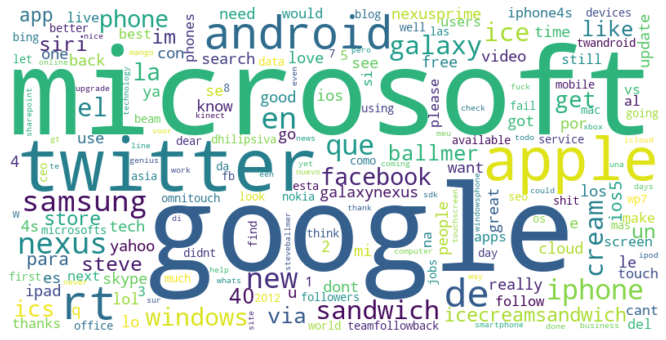

In [46]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Flatten the corpus into a single list of words
words = [word for sentence in tokenized_corpus for word in sentence]

# Count the frequency of each word
word_freq = Counter(words)

# Create a word cloud visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### Text embeddings

Text embeddings are a fundamental concept in Natural Language Processing (NLP) that allow us to represent text data as dense vectors of fixed length. Text embeddings capture the meaning and semantic relationships between words and documents, and enable us to apply machine learning algorithms to analyze and process text data.

Text embeddings can be generated using various techniques, such as Word2Vec, GloVe, and FastText, which are unsupervised learning algorithms that learn vector representations of words based on their co-occurrence statistics in a large corpus of text. These embeddings can be further improved by using supervised learning techniques that take into account the task-specific labels or feedback.

In this section, we will explore the concept of text embeddings and how to generate and use some of them. We will cover the basics of TD-IDF and GloVe.

### TF-IDF

TF-IDF stands for Term Frequency-Inverse Document Frequency. The basic idea behind TF-IDF is to give more weight to terms that appear frequently in a document but are rare in the corpus as a whole, as such terms are likely to be more informative and characteristic of the content of the document. 

By calling $D$ the set of documents (*tweets*), TF-IDF for a word $w$ in a document $d$ is calculated by multiplying two different metrics:$$\textrm{TF-IDF}(w, d, D) = \textrm{TF}(w, d) \times \textrm{IDF}(w, D)$$
Where :
    $$\textrm{TF}(w, d) = \log(1 + \textrm{freq}(w, d))$$
    $$\textrm{IDF}(w, D) = \log(\frac{|D|}{|\{d\in D, w \in d\}|})$$

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = df_train['TweetText'].values.copy()
vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', max_features=1000, strip_accents='unicode')
X_tf = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()

array(['10', '100', '1000aday', '11', '15', '16', '17', '18', '19', '1st',
       '20', '2008', '2010', '2011', '2012', '25', '30', '360', '39',
       '3g', '40', '4s', '50', '500', '70', '78k', '99',
       '_tashaaiwestend', 'aan', 'able', 'acabo', 'access', 'according',
       'account', 'accounts', 'actually', 'ad', 'add', 'addicted',
       'adobe', 'ads', 'advertising', 'adwords', 'age', 'agora', 'agree',
       'ah', 'ahora', 'ai', 'air', 'aka', 'al', 'allow', 'als', 'amazing',
       'amazon', 'analytics', 'android', 'android4', 'andy', 'announced',
       'announcement', 'announces', 'answer', 'antiguo', 'anymore', 'app',
       'apparently', 'apple', 'applies', 'apps', 'appsense', 'appstore',
       'aqui', 'article', 'asi', 'asia', 'asiaclassifiedtoday', 'ask',
       'ass', 'att', 'attacks', 'auf', 'augnl', 'autopilot', 'available',
       'avec', 'avoir', 'away', 'awesome', 'azure', 'baby', 'bad',
       'ballmer', 'bar', 'based', 'battery', 'battle', 'beam', 'beat',
    

In [48]:
X_tf.shape

(4090, 1000)

### Glove embedding

In [64]:
import numpy as np

# Load GloVe embeddings
def load_glove_embeddings(path):
    embeddings = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vector = np.array([float(x) for x in parts[1:]])
            embeddings[word] = vector
    return embeddings

glove_file = 'glove.twitter.27B.25d.txt'
glove_embeddings = load_glove_embeddings(glove_file)

# Transform text into GloVe embeddings
def transform_text_to_glove_embeddings(tokens, embeddings):

    # Compute average GloVe embedding
    embedding_dim = len(embeddings[next(iter(embeddings))])
    embedding_sum = np.zeros(embedding_dim)
    num_embeddings = 0
    for token in tokens:
        if token in embeddings:
            embedding_sum += embeddings[token]
            num_embeddings += 1
    if num_embeddings > 0:
        embedding_avg = embedding_sum / num_embeddings
    else:
        embedding_avg = np.zeros(embedding_dim)

    return embedding_avg


In [66]:
 train_texts["tokenized_text"]

0                          [ninguem, fala, cmgo, twitter]
1       [two, extremes, touch, interaction, microsoft,...
2       [microsoft, google, design, software, mobile, ...
3                [twitter, show, fuckin, retweets, bitch]
4       [jajajajaja, ptm, gigo, si, tuvieras, twitter,...
                              ...                        
4085    [rt, jlachance04, day, davislachance, braedonr...
4086    [hmmmm, lot, siri, features, dont, work, canad...
4087    [simon_townsend, microsoft, tests, proves, app...
4088    [workshop, med, technet, idag, interessant, ci...
4089    [whats, twitpeeps, hows, every, apple, user, l...
Name: tokenized_text, Length: 4090, dtype: object

In [65]:
train_texts["glove_embeddings"] = train_texts["tokenized_text"].apply(lambda x: transform_text_to_glove_embeddings(x, glove_embeddings))

StopIteration: 

In [ ]:
X["glove_embeddings"]

In [67]:
train_rep_glove = sentence_representations(train_texts, vocab_5k, GloveEmbeddings)
val_rep_glove = sentence_representations(test_texts, vocab_5k, GloveEmbeddings)

NameError: name 'sentence_representations' is not defined

#### Word2Vec

## The model

To run ramp locally you should modify `estimator.py` file which defines a `FeatureExtractor` class and a `Classifier` class.

- `FeatureExtractor` should hold code to create features from text.
- `Classifier` fits the model and predicts on data, as outputted by the `FeatureExtractor`. The prediction should be in the form of a (n_samples, 4) array with the probabilities of the four classes.

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [69]:
model = LogisticRegression(max_iter=1000)

# Fit the classifier on the transformed training data 
# and test it on the transformed validation data

model.fit(train_rep_glove, train_y)
predictions_glove = model.predict(val_rep_glove)

NameError: name 'train_rep_glove' is not defined

### Evaluation

#### Cross-validation

We use the testing set to evaluate the model

In [ ]:
test_texts = df_test.drop('Sentiment',axis = 1)
label_test = df_test['Sentiment']

label_test = le.fit_transform(label_test)

In [ ]:
labels_test

In [ ]:
from sklearn.metrics import classification_report

target_names = le.inverse_transform([0, 1, 2, 3])
print(classification_report(predictions_glove,label_test, target_names=target_names))

## RAMP test

In [ ]:
!ramp-test --submission starting_kit --quick-test

In [ ]:
!ramp-test --submission starting_kit